# Plot data for solvers

## Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import h5py as h5
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.sparse as sparse
import scipy.linalg as linalg
import itertools

from scipy import linalg as LA
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from scipy.sparse import coo_matrix

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
# To run interactive plot.
from matplotlib import interactive
interactive(True)
%matplotlib qt


In [2]:
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "text.usetex": False,
    "axes.formatter.use_mathtext": True,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.labelsize": 14
})



## Import data

In [3]:
dim = 2
has_all_data = True
data_filepaths = [
  ['../data/final/timed/results_boussinesq_solver_B_P_G.h5'],
  ['../data/final/timed/results_boussinesq_solver_B.h5'],
  ['../data/final/timed/results_boussinesq_solver_PU.h5'],
  ['../data/final/timed/results_boussinesq_solver_LU.h5'],
]

solver_names = ['BiCGSTAB + ILUT',
                'BiCGSTAB',
                'PardisoLU',
                'SparseLU',
                ]

In [4]:
def analytic(x, y, z, P, E, nu):
    r = [np.sqrt(x[i] ** 2 + y[i] ** 2) for i in range(len(x))]
    R = [np.sqrt(x[i] ** 2 + y[i] ** 2 + z[i] ** 2) for i in range(len(x))]
    ct = [x[i] / r[i] for i in range(len(x))]
    st = [y[i] / r[i] for i in range(len(x))]

    mu = E / (2*(1+nu))

    ur = [P*r[i]/(4*np.pi*mu) * (z[i] / R[i] ** 3 - (1-2*nu) /
                                 (R[i]*(z[i]+R[i]))) for i in range(len(x))]

    w = [P/(4*np.pi*mu) * (z[i] ** 2 / R[i] ** 3 + 2*(1-nu) / R[i])
         for i in range(len(x))]

    u = [ur[i] * ct[i] for i in range(len(x))]
    v = [ur[i] * st[i] for i in range(len(x))]

    srr = [P/(2*np.pi)*((1-2*nu) / (R[i]*(R[i]+z[i])) - 3 *
                        r[i] ** 2*z[i]/R[i] ** 5) for i in range(len(x))]
    szz = [-3*P/(2*np.pi)*z[i] ** 3/R[i] ** 5 for i in range(len(x))]
    stt = [P/(2*np.pi)*(1-2*nu)*(z[i]/R[i] ** 3 - 1 / (R[i]*(R[i]+z[i])))
           for i in range(len(x))]
    srz = [-3*P/(2*np.pi)*r[i]*z[i] ** 2/R[i] ** 5 for i in range(len(x))]

    sxx = np.array([srr[i] * ct[i] ** 2 + stt[i] *
                   st[i] ** 2 for i in range(len(x))])
    sxy = np.array([(srr[i]-stt[i]) * ct[i]*st[i] for i in range(len(x))])
    sxz = np.array([srz[i]*ct[i] for i in range(len(x))])
    syy = np.array([stt[i]*ct[i] ** 2 + srr[i]*st[i]
                   ** 2 for i in range(len(x))])
    syz = np.array([srz[i]*st[i] for i in range(len(x))])

    return [u, v, w, sxx, syy, szz, sxy, sxz, syz]

### Implicit error vs. number of iterations

In [5]:
data_p = {}
for solver_id, solver_data_filepath in enumerate(data_filepaths):
    data_solver = {}
    all_iterations = []
    all_error_implicit = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            print(data_filepath)
            # Iterations
            groups = list(data.keys())
            N_iter = len([g for g in groups if 'disp_implicit' in g])
            iterations = np.linspace(0, N_iter, N_iter, endpoint=False, dtype=int)
            nodes = [data.attrs['N_{:05d}'.format(i)] for i in range(N_iter)]
            N = np.arange(0, N_iter)
            errors_1 = []
            errors_2 = []
            errors_inf = []
            for i in range(N_iter):
                pos = data['domain_{:05d}/pos'.format(i)][:]
                # Displacements.
                disp_num = data['disp_implicit_{:05d}'.format(i)][:]
                disp_x, disp_y, disp_z = analytic(
                    pos[0], pos[1], pos[2], -1, 1, 0.33)[:3]
                # Displacements magnitude.
                displacement_mag_analytic = [
                    np.sqrt(x*x+y*y+z*z) for x, y, z in zip(disp_x, disp_y, disp_z)]
                disp_num_magnitude = [np.sqrt(
                    x*x + y*y + z*z) for x, y, z in zip(disp_num[0], disp_num[1], disp_num[2])]

                # Error.
                # err = np.array(displacement_mag_analytic) - \
                #     np.array(disp_num_magnitude)
                # err_norm = LA.norm(err, 1) / \
                #     LA.norm(displacement_mag_analytic, 1)
                # errors_1.append(err_norm)

                err = np.array(displacement_mag_analytic) - \
                    np.array(disp_num_magnitude)
                err= np.nan_to_num(err, nan=1)
                err_norm = LA.norm(err, 2) / \
                    LA.norm(displacement_mag_analytic, 2)
                errors_2.append(err_norm)

                # err = np.array(displacement_mag_analytic) - \
                #     np.array(disp_num_magnitude)
                # err_norm = LA.norm(err, np.inf) / \
                #     LA.norm(displacement_mag_analytic, np.inf)
                # errors_inf.append(err_norm)

            all_iterations.append(iterations)
            all_error_implicit.append(errors_2)
    
    # store to dictionary.
    data_solver['iterations'] = all_iterations
    data_solver['error'] = all_error_implicit

    data_p[solver_names[solver_id]] = data_solver

../data/final/timed/results_boussinesq_solver_B_P_G.h5
../data/final/timed/results_boussinesq_solver_B.h5
../data/final/timed/results_boussinesq_solver_PU.h5
../data/final/timed/results_boussinesq_solver_LU.h5


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
linestyles=['dashdot', 'dashdot', 'dashdot', '-', '-']
markers = ['x', '>', '*', 'd', 'o']
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:orange', 'tab:red']

for solver_id, solver in enumerate(data_p.keys()):
    all_iterations = data_p[solver]['iterations']
    all_error_implicit = data_p[solver]['error']
    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    error_implicit = np.mean(all_error_implicit, axis=0)    
    # Plot implicit error norm. 
    ax.semilogy(iterations, error_implicit, marker=markers[solver_id], ls=linestyles[solver_id], color=colors[solver_id], label=solver)
        
ax.grid(True, which="both")
ax.set_ylabel(r'$e_{2}$')
ax.set_xlabel('iteration')
ax.set_ylim(top=1e-2)
ax.legend(loc='lower left', ncol=1)
fig.tight_layout()
if 1:
    plt.savefig('../manuscript/figures/solvers_convergence.png', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()


## solver iterations

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
linestyles=['dashdot', 'dashdot', 'dashdot', '-', '-']
markers = ['x', '>', '*', 'd', 'o']
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:orange', 'tab:red']

for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_solver_iterations = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            groups = list(data.keys())
            N_iter = len([g for g in groups if 'disp_implicit' in g])
            iterations = np.linspace(0, N_iter, N_iter, endpoint=False, dtype=int)
            
            solver_iterations = [
                data.attrs['N_solver_iters_{:05d}'.format(i)] for i in iterations]

            all_iterations.append(iterations)
            all_solver_iterations.append(solver_iterations)

    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    solver_iterations = np.mean(all_solver_iterations, axis=0)    
    # Plot.
    ax.semilogy(iterations, solver_iterations, marker=markers[solver_id], ls=linestyles[solver_id], color=colors[solver_id], label=solver_names[solver_id])

ax.grid(True, which="both")
ax.set_ylabel('solver iterations')
ax.set_xlabel('iteration')
ax.legend()
fig.tight_layout()
if 1:
    plt.savefig('../results/solvers_iterations.png', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()

## Solve times


In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
linestyles=['dashdot', 'dashdot', 'dashdot', '-', '-']
markers = ['x', '>', '*', 'd', 'o']
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:orange', 'tab:red']

for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_times = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            print(data_filepath)
            groups = list(data.keys())
            N_iter = len([g for g in groups if 'disp_implicit' in g])
            iterations = np.linspace(0, N_iter, N_iter, endpoint=False, dtype=int)

            times = [data.attrs['solver_duration_{:05d}'.format(i, i)] for i in iterations]

            all_iterations.append(iterations)
            all_times.append(times)

    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    times = np.mean(all_times, axis=0)    
    # Plot.
    ax.semilogy(iterations, times, marker=markers[solver_id], ls=linestyles[solver_id], color=colors[solver_id], label=solver_names[solver_id])

ax.grid(True, which="both")
ax.set_ylabel('solve time')
ax.set_xlabel('iteration')
ax.legend()
fig.tight_layout()
if 1:
    plt.savefig('../results/solvers_times.png', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()

../data/final/timed/results_boussinesq_solver_B_G_P.h5
../data/final/timed/results_boussinesq_solver_B_G.h5
../data/final/timed/results_boussinesq_solver_B.h5
../data/final/timed/results_boussinesq_solver_PU.h5
../data/final/timed/results_boussinesq_solver_LU.h5


# All solver images

../data/final/timed/results_boussinesq_solver_B_P_G.h5
../data/final/timed/results_boussinesq_solver_B.h5
../data/final/timed/results_boussinesq_solver_PU.h5
../data/final/timed/results_boussinesq_solver_LU.h5


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


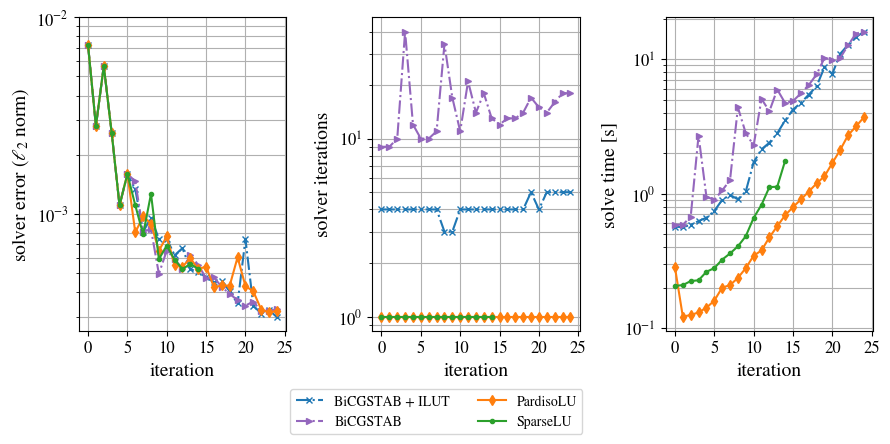

In [6]:
fig = plt.figure(figsize=(9, 4),tight_layout=True)
gs = gridspec.GridSpec(1, 3)
linestyles=['dashdot', 'dashdot', '-', '-']
markers = ['x', '>', 'd', 'o']
colors = ['tab:blue', 'tab:purple', 'tab:orange', 'tab:green']
markersizes = [5, 5, 5, 3]

ax = fig.add_subplot(gs[0, 0])
for solver_id, solver in enumerate(data_p.keys()):
    all_iterations = data_p[solver]['iterations']
    all_error_implicit = data_p[solver]['error']
    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    error_implicit = np.mean(all_error_implicit, axis=0)    
    # Plot implicit error norm. 
    ax.semilogy(iterations, error_implicit, ms=markersizes[solver_id], marker=markers[solver_id], ls=linestyles[solver_id], color=colors[solver_id], label=solver)
        
ax.grid(True, which="both")
ax.set_ylabel(r'solver error ($\ell_2$ norm)')
ax.set_xlabel('iteration')
ax.set_ylim(top=1e-2)
ax.set_xticks(ticks=np.arange(0, 26, 5))
ax.set_xticklabels(labels=np.arange(0, 26, 5))

# solver iterations
ax = fig.add_subplot(gs[0, 1])
for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_solver_iterations = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            groups = list(data.keys())
            N_iter = len([g for g in groups if 'disp_implicit' in g])
            iterations = np.linspace(0, N_iter, N_iter, endpoint=False, dtype=int)
            
            solver_iterations = [
                data.attrs['N_solver_iters_{:05d}'.format(i)] for i in iterations]

            all_iterations.append(iterations)
            all_solver_iterations.append(solver_iterations)

    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    solver_iterations = np.mean(all_solver_iterations, axis=0)    
    # Plot.
    ax.semilogy(iterations, solver_iterations, ms=markersizes[solver_id], marker=markers[solver_id], ls=linestyles[solver_id], color=colors[solver_id], label=solver_names[solver_id])
ax.grid(True, which="both")
ax.set_ylabel('solver iterations')
ax.set_xlabel('iteration')
ax.set_xticks(ticks=np.arange(0, 26, 5))
ax.set_xticklabels(labels=np.arange(0, 26, 5))

# Solve times.
ax = fig.add_subplot(gs[0, 2])
for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_times = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            print(data_filepath)
            groups = list(data.keys())
            N_iter = len([g for g in groups if 'disp_implicit' in g])
            iterations = np.linspace(0, N_iter, N_iter, endpoint=False, dtype=int)

            times = [data.attrs['solver_duration_{:05d}'.format(i, i)] for i in iterations]

            all_iterations.append(iterations)
            all_times.append(times)

    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    times = np.mean(all_times, axis=0)    
    # Plot.
    ax.semilogy(iterations, times, ms=markersizes[solver_id], marker=markers[solver_id], ls=linestyles[solver_id], color=colors[solver_id], label=solver_names[solver_id])

ax.grid(True, which="both")
ax.set_ylabel('solve time [s]')
ax.set_xlabel('iteration')
ax.set_xticks(ticks=np.arange(0, 26, 5))
ax.set_xticklabels(labels=np.arange(0, 26, 5))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles = handles, labels = labels, loc='upper left', bbox_to_anchor=(0.32, 0.03), ncol = 2)

fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

if 1:
    plt.savefig('../manuscript/figures/solvers_iter_times.eps', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()

# Spectrum and matrix

In [7]:
print('WARNING: can take long due to large matrices.')
data_filepath = '../data/final/timed/results_boussinesq_solver_B_P_G.h5'
output_file_postfix = '_eigenvalues'
out_file = '../data/final/' + data_filepath.split('/')[-1].split('.h5')[0] + output_file_postfix + '.json'
iterations = [1, 5, 11]

eigen_data = {}
# compute new eigenvectors.

if 0:
    with h5.File(data_filepath, "r") as dataFile:
        for iteration in iterations:
            print(iteration)
            i, j, val = dataFile["Matrix_{:05d}".format(iteration)][()]
            i = (i-1).astype(int)
            j = (j-1).astype(int)
            mat = sparse.coo_matrix((val, (i, j)))
            # better eigenvalue algorithms available for dense matrices
            # dense = mat.toarray()
            # ‘LM’ : largest magnitude
            # ‘SM’ : smallest magnitude
            # ‘LR’ : largest real part
            # ‘SR’ : smallest real part
            # ‘LI’ : largest imaginary part
            # ‘SI’ : smallest imaginary part
            eVal=sparse.linalg.eigs(mat, k=50, which='LM', return_eigenvectors=False)
            serializable_eVal = [[e.real, e.imag] for e in eVal]
            eigen_data['{}'.format(iteration)] = serializable_eVal
        
        # Save eigenvalues to file.
        with open(out_file, "w") as write_file:
            json.dump(eigen_data, write_file, indent=2)
else:
    #import
    for iteration in iterations:
        with open(f'../data/final/results_boussinesq_solver_B_P_G_eigenvalues_{iteration}.json') as dataFile:
            d = json.load(dataFile)
            eigen_data[str(iteration)] = d[str(iteration)]
    


iteration 1
iteration 5
iteration 11


MemoryError: Unable to allocate 71.6 GiB for an array with shape (98001, 98001) and data type float64

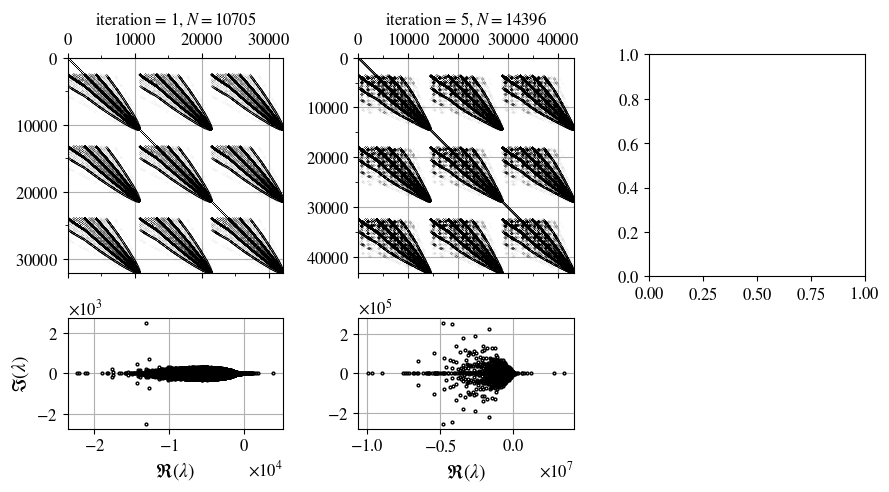

In [8]:
print('WARNING: Can take up to 10 minutes due to large matrices!')

with h5.File(data_filepath, "r") as dataFile:
    fig = plt.figure(figsize=(9,5), tight_layout=True)
    gs = gridspec.GridSpec(2, 3, height_ratios=[1,0.5])

    for col_idx, iteration in enumerate(iterations):
        print('iteration', iteration)
        ax = fig.add_subplot(gs[0, col_idx])

        M = dataFile["Matrix_{:05d}".format(iteration)][:] # array of triplets!
        dataType = dataFile['domain_{:05d}/types'.format(iteration)][:] # Node type (boundary or interior)
        # convert triplets to matrix
        N = 3*len(dataType)
        row = M[0,:] - 1
        col = M[1,:] - 1
        val = M[2,:]
        matrix = coo_matrix((val, (row, col)), shape = (N, N)).toarray()
        M = matrix
        ax.spy(M, ms = 0.01, marker = '.', c = 'black')
        ax.grid()
        
        
        ax.set_title(f'iteration = {iteration}, $N={len(dataType)}$')
        ticks = np.linspace(min(row), max(row), 8)
        ticks = [int(t) for t in ticks]
        ax.xaxis.set_major_locator(MultipleLocator(10000 if col_idx < 2 else 30000))

        ax.xaxis.set_minor_locator(MultipleLocator(5000 if col_idx < 2 else 15000))
        # ax.set_xticklabels([])
        ax.yaxis.set_major_locator(MultipleLocator(10000 if col_idx < 2 else 30000))
        ax.yaxis.set_minor_locator(MultipleLocator(5000 if col_idx < 2 else 15000))
        # ax.set_yticklabels([])

        ax = fig.add_subplot(gs[1, col_idx])
        eVal = [complex(val[0] + 1j * val[1]) for val in eigen_data['{}'.format(iteration)]]
        ax.plot(np.real(eVal), np.imag(eVal), 'ko', markerfacecolor="none", ms=2)
        ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
        ax.set_xlabel('$\Re (\lambda)$')
        ax.grid()
        if (col_idx == 0):
            ax.set_ylabel('$\Im (\lambda)$')

fig.tight_layout()
if 0:
    plt.savefig('../manuscript/figures/spectra_bou.eps', dpi=300, transparent=False, bbox_inches='tight')
plt.show()